In [30]:
import numpy as np
import cv2
from image_geometry import PinholeCameraModel

In [3]:
# Prepare visualisation tools
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

def bgrshow(bgr):
    imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    
def imshow(img):
    plt.figure(figsize=(9,8), dpi= 80, facecolor='w', edgecolor='k')
    #plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(img)
    plt.show()

In [4]:
# Load jpegs
import glob
raw = []
for im_path in sorted(glob.glob("frames/*.png")):
    bgr = cv2.imread(im_path,cv2.IMREAD_COLOR)
    raw.append(bgr)

In [5]:
# Prepare the AI filter
from AntiInstagram import AntiInstagram
ai = AntiInstagram()

output_scale = 1
color_balance_percentage = 0.8

try:
    raw0 = raw[0]
except (NameError, IndexError) as e:    
    print("No image in raw[0] to calibrate AI filter")
else:
    ai.calculate_color_balance_thresholds(raw0, output_scale, color_balance_percentage)

In [24]:
from sensor_msgs.msg import CameraInfo
from duckietown_utils.yaml_wrap import yaml_load_file

ci = CameraInfo()

filename ='old_intrinsics.yaml'
calib_data = yaml_load_file(filename)

ci.width  = calib_data['image_width']
ci.height = calib_data['image_height']
ci.K      = np.array(calib_data['camera_matrix']['data']).reshape((3,3))
ci.D      = np.array(calib_data['distortion_coefficients']['data']).reshape((1,5))
ci.R      = np.array(calib_data['rectification_matrix']['data']).reshape((3,3))
ci.P      = np.array(calib_data['projection_matrix']['data']).reshape((3,4))

mapx = np.ndarray(shape=(ci.height, ci.width, 1), dtype='float32')
mapy = np.ndarray(shape=(ci.height, ci.width, 1), dtype='float32')
mapx, mapy = cv2.initUndistortRectifyMap(ci.K, ci.D, ci.R, ci.P, 
                     (ci.width, ci.height), cv2.CV_32FC1, mapx, mapy)

H = np.array([-3.589767590401803e-05, -0.00023491693147080584, -0.1374201532070648,
               0.0008247535901185687, -5.00225097638814e-06,   -0.2685590146427659, 
              -5.664504414708967e-05, -0.006300114132830898,    1.0])
H = np.reshape(H,(3,3))

In [7]:
# input: rectified image
# output: distorted image
# NOTE: DOES NOT WORK
def redistort(rect):
    invK = np.linalg.inv(ci.K)
    invR = np.linalg.inv(ci.R)
    invmapx = np.ndarray(shape=(ci.height, ci.width, 1), dtype='float32')
    invmapy = np.ndarray(shape=(ci.height, ci.width, 1), dtype='float32')
    invmapx, invmapy = cv2.initUndistortRectifyMap(invK, ci.D, invR, ci.P, 
                         (ci.width, ci.height), cv2.CV_32FC1, invmapx, invmapy)
    cv_image_dist = np.zeros(np.shape(rect))
    return cv2.remap(rect, invmapx, invmapy, cv2.INTER_CUBIC, cv_image_dist)

In [8]:
# Rectifies image using pinhole camera model
def rectify(cv_image_raw):
    cv_image_rectified = np.zeros(np.shape(cv_image_raw))
    return cv2.remap(cv_image_raw, mapx, mapy, cv2.INTER_CUBIC, cv_image_rectified)

In [9]:
hsv_red1 = np.array([  0,140,100])
hsv_red2 = np.array([ 15,255,255])
hsv_red3 = np.array([165,140,100])
hsv_red4 = np.array([180,255,255])
cutoff   = 180

# input is full res raw bitmaps
# output is full res rectified, cropped, stop lines
def preprocess(img, crop=True):
    rect = rectify(img)  # rectify
    if crop:
        crpd = rect[cutoff:]  # crop
    else:
        crpd = rect  
    aied = ai.apply_color_balance(crpd, output_scale)  # color balance
    hsv = cv2.cvtColor(aied, cv2.COLOR_BGR2HSV)       
    bw1 = cv2.inRange(hsv, hsv_red1, hsv_red2)
    bw2 = cv2.inRange(hsv, hsv_red3, hsv_red4)
    red = cv2.bitwise_or(bw1, bw2)  # select red       
    return red

In [10]:
# Homography / ground projection tools
from geometry_msgs.msg import Point
from duckietown_msgs.msg import Pixel

def ground2pixel(point):
    if type(point) != Point:
        point = Point(point[0],point[1],0)
    ground_point = np.array([point.x, point.y, 1.0])

    image_point = np.linalg.solve(H, ground_point)

    image_point = image_point / image_point[2]

    pixel = Pixel()

    pixel.u = image_point[0]
    pixel.v = image_point[1]

    return (int(image_point[0]), int(image_point[1]))

def pixel2ground(pixel):
    uv_raw = np.array([pixel.u, pixel.v])
#   if not self.rectified_input:
#       uv_raw = self.pcm.rectifyPoint(uv_raw)
    #uv_raw = [uv_raw, 1]
    uv_raw = np.append(uv_raw, np.array([1]))
    ground_point = np.dot(H, uv_raw)
    point = Point()
    x = ground_point[0]
    y = ground_point[1]
    z = ground_point[2]
    point.x = x / z
    point.y = y / z
    point.z = 0.0
    return point

In [11]:
# origin: (x,y) axle coordinates (meters) of the near-left corner of the square
# side:   side in meters of square on the ground 
# w:      side in pixels of the output image

def ground_project2(image, origin, side, w):
    # H assumes incoming image resolution is VGA (640x480) use output_scale to fix
    # pixel at bottom center is x: 0.128 y: 0.00344677851347
    # x axis is longitudinal, y axis is to the left
    # bottom edge aligned
    # don't think backwards
    oh, ow = np.shape(image) #original width, original height
    side = float(side)
    x0 = origin[0]
    y0 = origin[1]+side/2
    res = float(w)/side #pix/m in square
    
    output = np.zeros((w, w))
    pix = Pixel()
    # loop over input image pixels
    for row in range(oh):
        for column in range(ow):
            if image[row, column] == 0: 
                # if pixel is OFF skip it
                continue
            # if pixel is ON find out where it belongs on our output square
            
            pix.v = row/output_scale+cutoff
            pix.u = column/output_scale
            
            gnd = pixel2ground(pix)
            # now I have ground plane coordinates wrt axel frame
            # find correpsonding pixel in square ("ground pixel x and y")
            gpx = int(w-(gnd.x - x0)*res) # column
            gpy = int( -(gnd.y - y0)*res) # row

            if gpx < w and gpx >= 0 and gpy < w and gpy >= 0:
                output[gpx, gpy] = image[row, column]

    return output

In [12]:
# input: gnd:    (x,y) coordinates of point in intersection coordinates
#        origin: (x,y) origin of the birds eye view in intersection coordinates
#        side:   side of the square captured in the birds eye view 
#        w:      width (equal to height) of the birds eye view image
# output: pixel coordinates of the point in the birds-eye-view 
def intersection2map(gnd, origin, side, w):
    side = float(side)
    x0 = origin[0]
    y0 = origin[1]+side/2
    res = float(w)/side # pix/m in square
    # now I have ground plane coordinates wrt axel frame
    # find correpsonding pixel in square ("ground pixel x and y")
    gpx = int(w-(gnd[0] - x0)*res) #column
    gpy = int(-(gnd[1] - y0)*res) #row
    return (gpx, gpy)

In [13]:
### works on absolute image pixel values
# BEWARE ARTIFACTS if you try to draw outside of the image bounds
def draw_segment(image, pt0, pt1, color):
    defined_colors = {
        'red': ['rgb', [1, 0, 0]],
        'green': ['rgb', [0, 1, 0]],
        'blue': ['rgb', [0, 0, 1]],
        'yellow': ['rgb', [1, 1, 0]],
        'magenta': ['rgb', [1, 0, 1]],
        'cyan': ['rgb', [0, 1, 1]],
        'white': ['rgb', [1, 1, 1]],
        'black': ['rgb', [0, 0, 0]]}
    _color_type, [r, g, b] = defined_colors[color]
    cv2.line(image, pt0, pt1, (b * 128, g * 128, r * 128), 3)
    return image

In [14]:
map_features = yaml_load_file('map/stoplines.yaml')
pts = map_features.values()[0]
sgs = map_features.values()[1]

In [15]:
from numpy import sin, cos, pi
# pose is (x,y,theta) - (0,0,0) is the target exit pose. 
def ground2intersection(g, pose):
    t = pose[2]
    d = np.array([pose[0],pose[1]])
    R = [[cos(t), -sin(t)],[sin(t), cos(t)]]
    i = np.dot(R,g)
    return i + d

def intersection2ground(pt, pose):
    pt=[pt[0],pt[1]]
    t = pose[2]
    d = np.array([pose[0],pose[1]])
    R = [[cos(t), sin(t)],[-sin(t), cos(t)]]
    i = np.dot(R, pt-d)
    return (i[0],i[1])   

def intersection2pixel(pt, pose):
    gnd = intersection2ground(pt, pose)
    return ground2pixel(gnd)

def pixel2intersection(px, pose):
    gnd = pixel2ground(pt)
    return ground2intersection(gnd, pose)

In [16]:
# takes RECTIFIED image and robot pose wrt to intersection ref frame
def overlay(img, pose):
    # use pose to transform the overlay
    for seg in sgs:
        pt0 = intersection2pixel(pts[seg['points'][0]][1],pose)
        pt1 = intersection2pixel(pts[seg['points'][1]][1],pose)
        print(pt0, " - ", pt1)
        col = 'white'#seg['color']
        img = draw_segment(img, pt0, pt1, col)

    return img

In [17]:
# assume img is a 1m x 1m square 
def showOnMap(img, pose):
    x = pose[0]
    y = pose[1]
    # use pose to transform the overlay
    pt0 = intersection2map((x,y), [0, 0], 1, h)
    img = draw_segment (img, pt0, pt0, 'white')
    return img

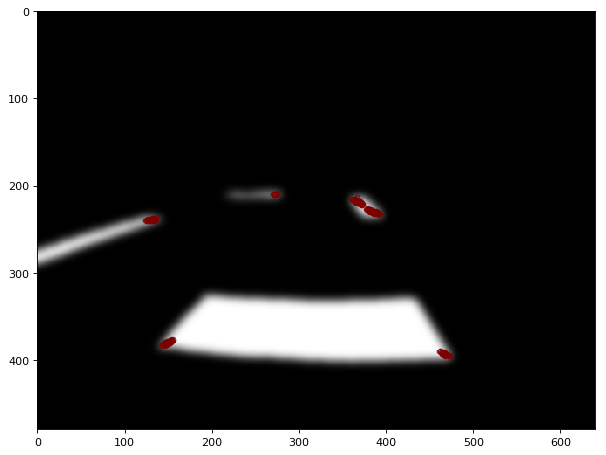

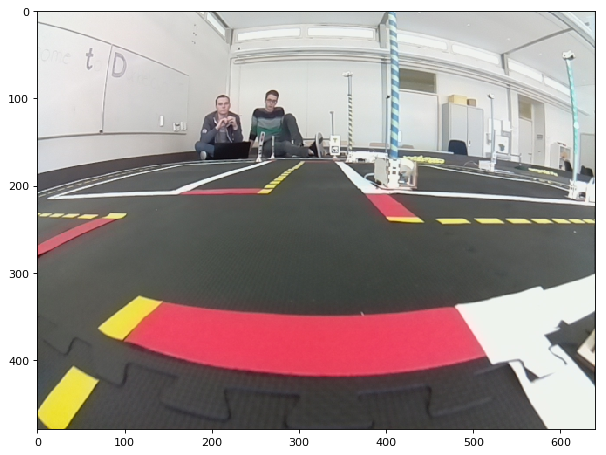

In [18]:
cutoff = 0
img = raw[0]
red = preprocess(img)

e#cv.ProjectPoints2(objectPoints, rvec, tvec, cameraMatrix, distCoeffs, imagePoints, dpdrot=None, dpdt=None, dpdf=None, dpdc=None, dpddist=None)
#pose = [-0.09, -.31, pi/2] # before right turn

#add border to input image so we can see FOV borders in the reprojection
#red[:,(0,w-1)] = 128
#red[(0,h-1),:] = 128
#square = ground_project2(red, [0, 0], 1, h)
#imshow(square)
#out = overlay(red, pose)
#imshow(out)


In [19]:
# imageH means homogeneus coordinates in image frame
def pixel2imageH(u,v,ci):
    p = np.dot(np.linalg.inv(ci.K), np.array([u,v,1], dtype='float'))
    #x = float(u)-ci.width/2  #- 0.5
    #y = float(v)-ci.height #- 0.5
    return (p[0]/p[2],p[1]/p[2],1)

def imageH2pixel(pt,ci):
    u = (pt[0] )*ci.width
    v = (pt[1] )*ci.height
    return (int(u),int(v))

In [20]:
def 
pr = []
for pt in pts:
    pt = np.concatenate([np.array(pt), [0]])
    pri = np.dot(ci.P, pt)
    pr.append([pri])
    
pr = np.array(pr)

array([[ 311.58117986,    0.        ,  321.70691266],
       [   0.        ,  311.65761083,  239.56256041],
       [   0.        ,    0.        ,    1.        ]])

Camera frame coordinates =  [(-0.99, 0.7, 1), (-0.8, 0.55, 1), (-0.7, 0.55, 1), (-0.6, 0.55, 1)]
distorted pixel coords = 
 [[[ 101.293804    376.62753795]]

 [[ 124.51107289  355.58380668]]

 [[ 142.81506798  359.6072591 ]]

 [[ 162.98461006  363.3558424 ]]]
rectified pixel coord = 
 [[[ 115.59330371  381.04619963    1.        ]]

 [[ 154.21280994  346.30763838    1.        ]]

 [[ 174.53886584  346.30763838    1.        ]]

 [[ 194.86492175  346.30763838    1.        ]]]


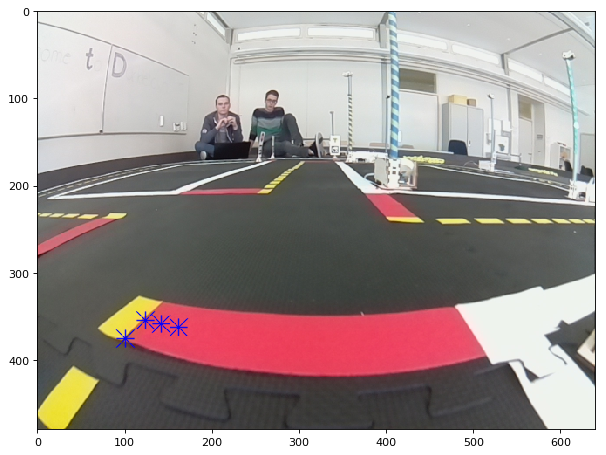

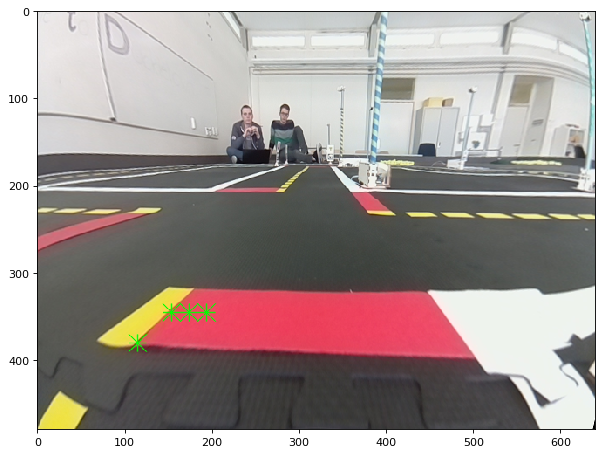

In [31]:
pts = [(-0.99,0.7,1),(-0.8,0.55,1),(-0.7,0.55,1),(-0.6,0.55,1)]
print('Camera frame coordinates = ', pts)
ptsIn  = np.array(pts, dtype='float')

rvec = tvec = np.array([[0,0,0]], dtype='float')

ptsOut, _ = cv2.projectPoints(ptsIn, rvec, tvec, ci.K, ci.D)
pd = ptsOut
print('distorted pixel coords = \n', pd)

pr = []
for pt in pts:
    pt = np.concatenate([np.array(pt), [0]])
    pri = np.dot(ci.P, pt)
    pr.append([pri])
    
pr = np.array(pr)
print('rectified pixel coord = \n', pr)


orig = raw[0]
rec = rectify(orig)
dis = np.copy(orig)
for i in range(len(pts)):
    cv2.drawMarker(dis, (int(pd[i][0][0]),int(pd[i][0][1])), (255,0,0), markerType=cv2.MARKER_STAR,
               markerSize=20, thickness=1, line_type=cv2.LINE_AA)
    cv2.drawMarker(rec, (int(pr[i][0][0]),int(pr[i][0][1])), (0,255,0), markerType=cv2.MARKER_STAR, 
               markerSize=20, thickness=1, line_type=cv2.LINE_AA)
bgrshow(dis)
bgrshow(rec)

Rectified pixel coordinates =  (480, 360)
homogeneous rectified camera coordinates =  (0.5789808942095992, 0.41483614820884729, 1)
Distorted  [ 456.60946323  343.22892027]


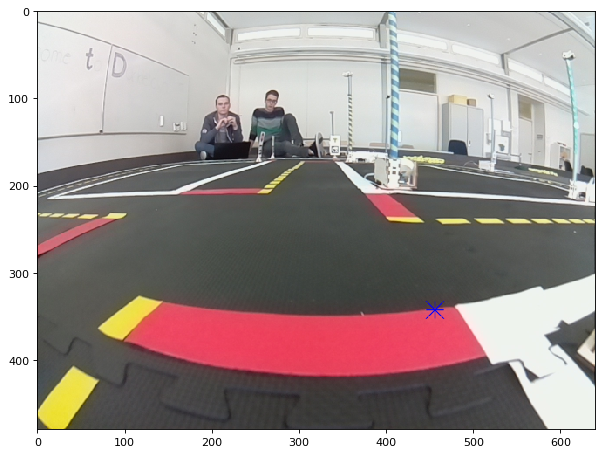

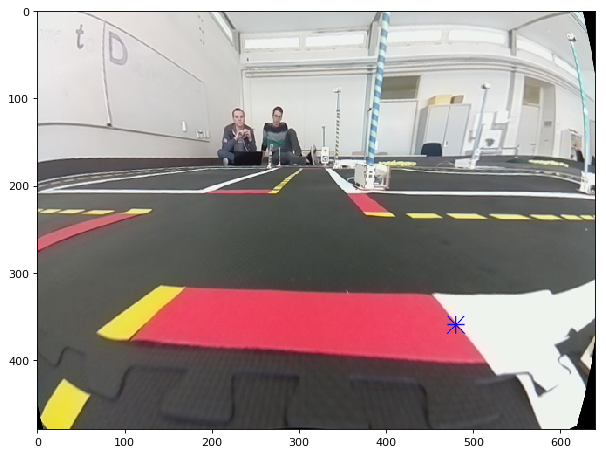

In [86]:
orig = raw[0]
img = rectify(orig)
mkd = np.copy(orig)

u,v = (640*3/4, 480*3/4)
print('Rectified pixel coordinates = ', (u,v))
pt = pixel2imageH(u, v, ci)
print('homogeneous rectified camera coordinates = ', pt)
# works on image coordinates
# ci.K 'camera_matrix'
# ci.D 'distortion_coefficients'
# ci.R 'rectification_matrix'
# ci.P 'projection_matrix'
# transform pixel 
rvec = tvec = np.array([[0,0,0]], dtype='float')
ptsIn  = np.array([pt], dtype='float')
ptsOut, jac = cv2.projectPoints(ptsIn, rvec, tvec, ci.K, ci.D)
out = ptsOut[0][0]
print('Distorted ',out)


cv2.drawMarker(mkd, (int(out[0]),int(out[1])), (255,0,0), markerType = cv2.MARKER_STAR,
               markerSize=20, thickness=1, line_type=cv2.LINE_AA)
cv2.drawMarker(img, (int(u),int(v)),(255,0,0), markerType=cv2.MARKER_STAR, 
               markerSize=20, thickness=1, line_type=cv2.LINE_AA)
bgrshow(mkd)
bgrshow(img)


In [205]:
print(ci.D)

[[-0.29446677  0.07014313  0.00058599 -0.00066978  0.        ]]


(-2, 256)  -  (-139, 255)
(-1292, 502)  -  (1622, -121)
(1112, -96)  -  (711, -77)
(-211, 482)  -  (157, 258)


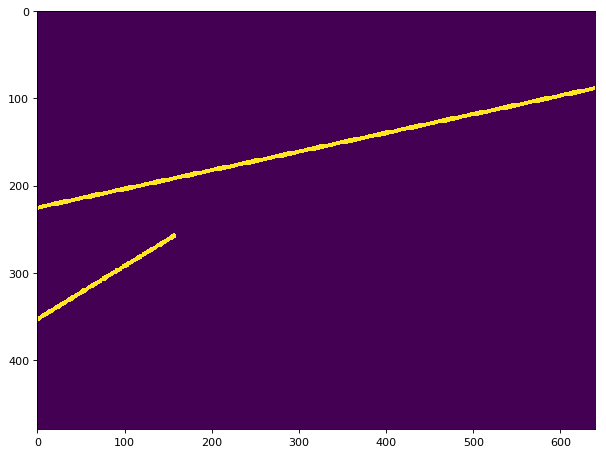

(-2, 256)  -  (-139, 255)
(-1292, 502)  -  (1622, -121)
(1112, -96)  -  (711, -77)
(-211, 482)  -  (157, 258)


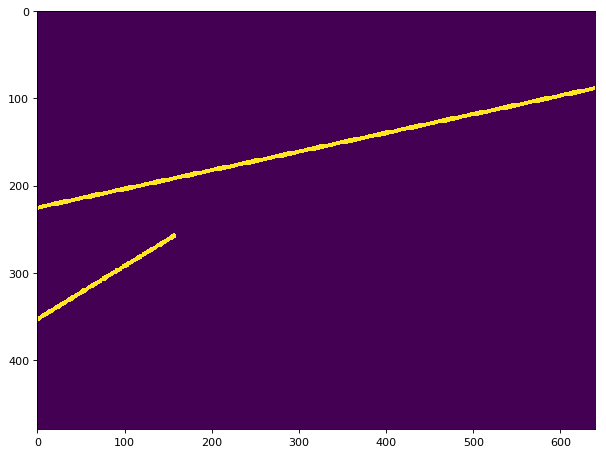

(-2, 256)  -  (-139, 255)
(-1292, 502)  -  (1622, -121)
(1112, -96)  -  (711, -77)
(-211, 482)  -  (157, 258)


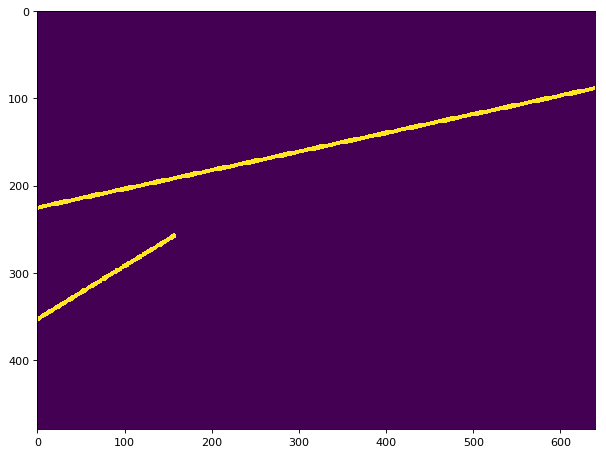

(-2, 256)  -  (-139, 255)
(-1292, 502)  -  (1622, -121)
(1112, -96)  -  (711, -77)
(-211, 482)  -  (157, 258)


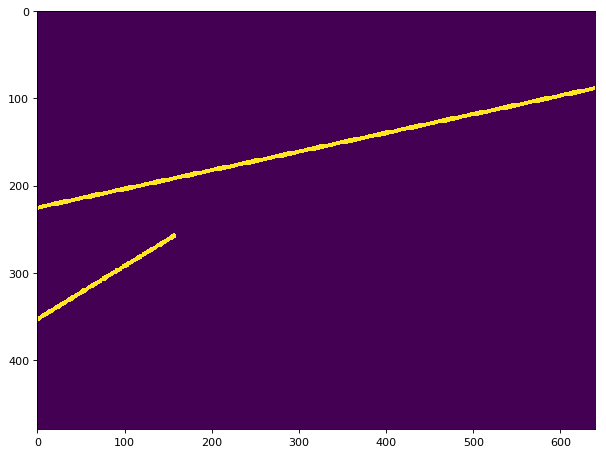

(-2, 256)  -  (-139, 255)
(-1292, 502)  -  (1622, -121)
(1112, -96)  -  (711, -77)
(-211, 482)  -  (157, 258)


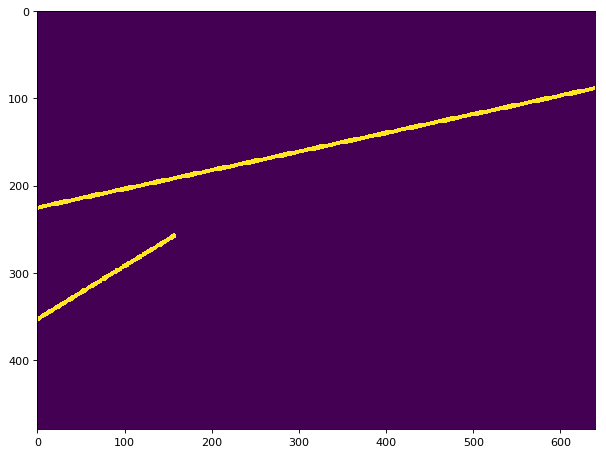

(328, 512)  -  (327, 260)
(157, 258)  -  (11, 256)
(-855, 535)  -  (1112, -96)
(673, -75)  -  (325, -58)


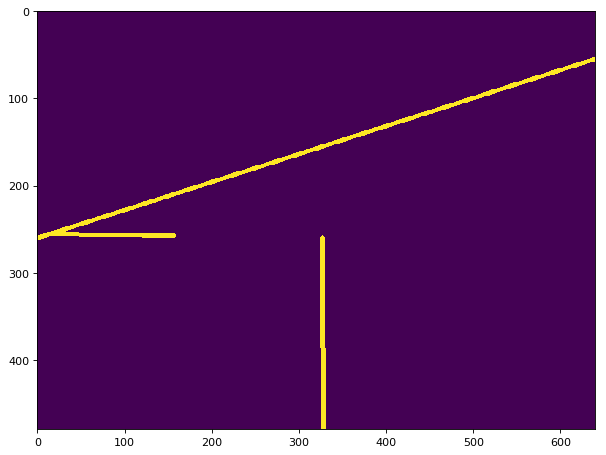

In [104]:
poses = []
thetas = np.array([0,2,4,6,8,10])/10*pi/2

for t in thetas:
    poses.append([-.32*cos(t), -0.32+0.32*sin(t), t])
for i in range(6):
    background = np.zeros((h,w))
    out = overlay(background, poses[i])
    imshow(out)

In [ ]:
pose = np.array([-0.3,0.3,-pi/2])
ground = np.array([0.3,0])
inters = ground2intersection(ground,pose)
ground2 = intersection2ground(inters,pose)
print("error = ",ground-ground2);

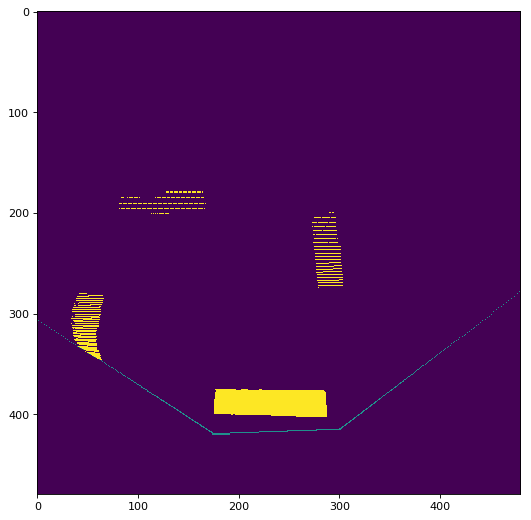

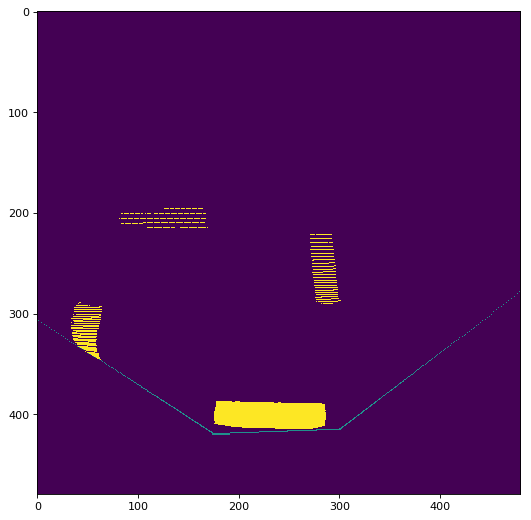

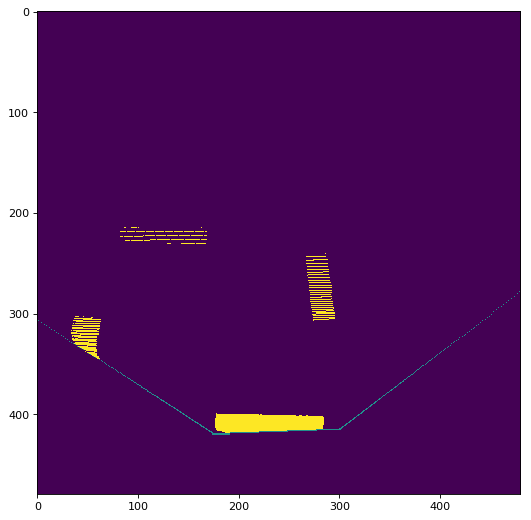

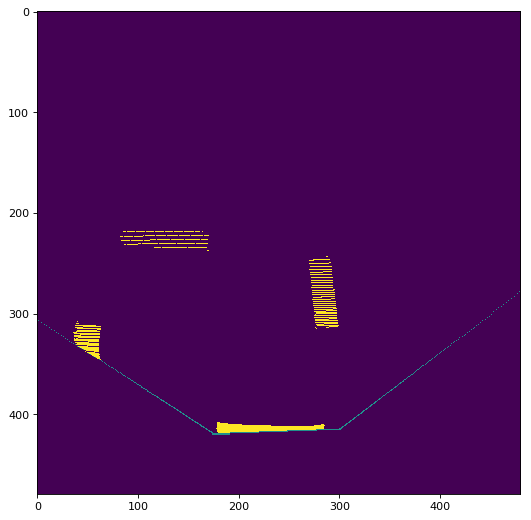

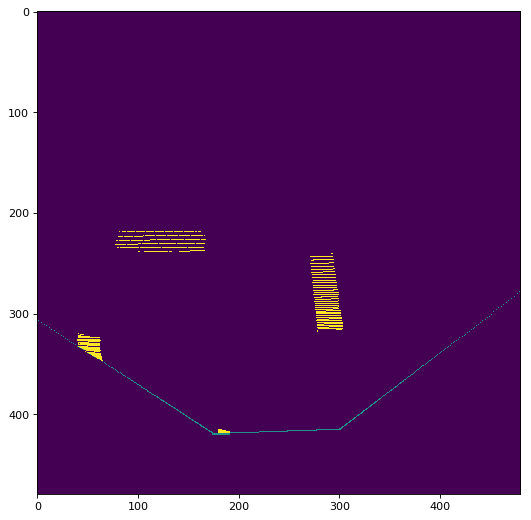

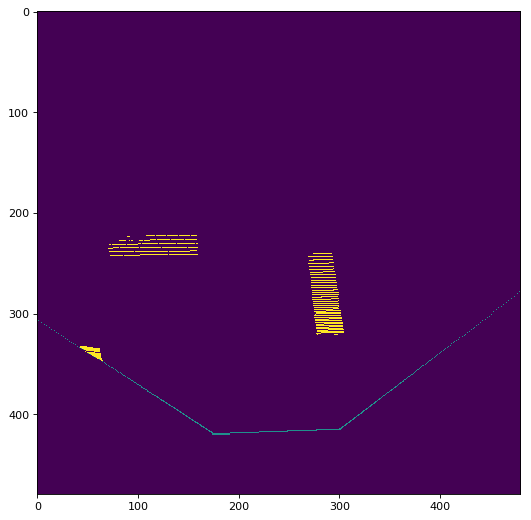

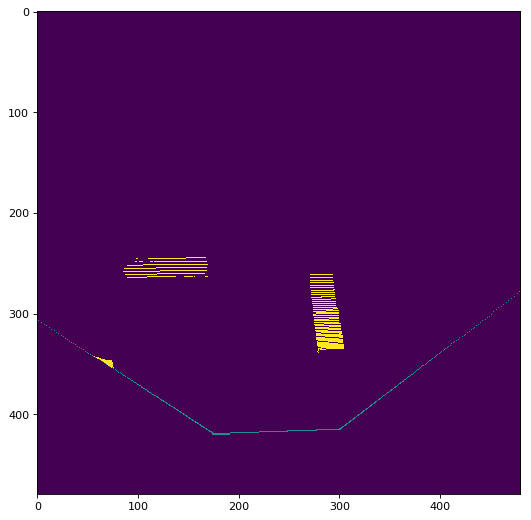

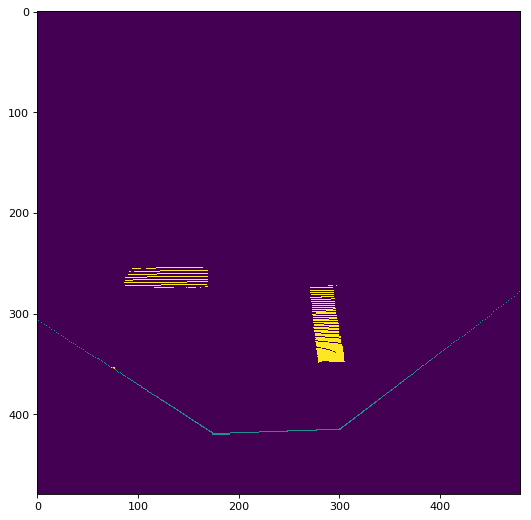

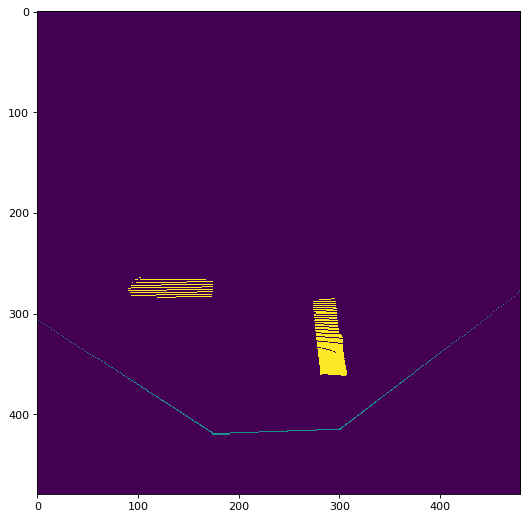

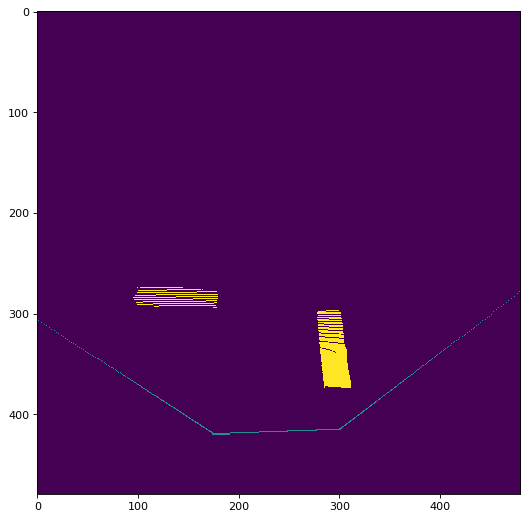

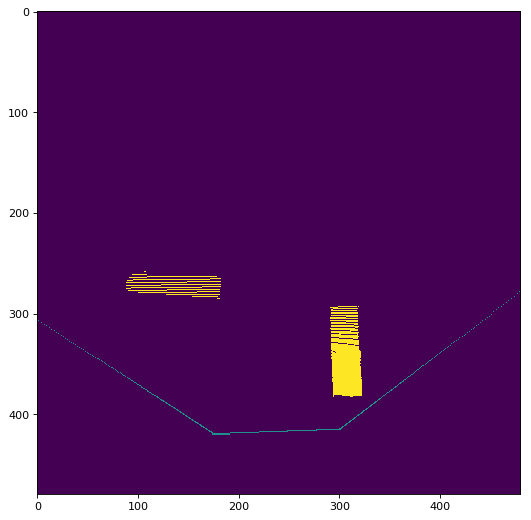

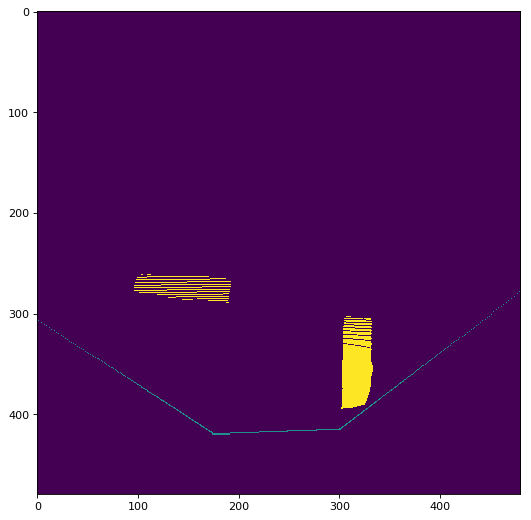

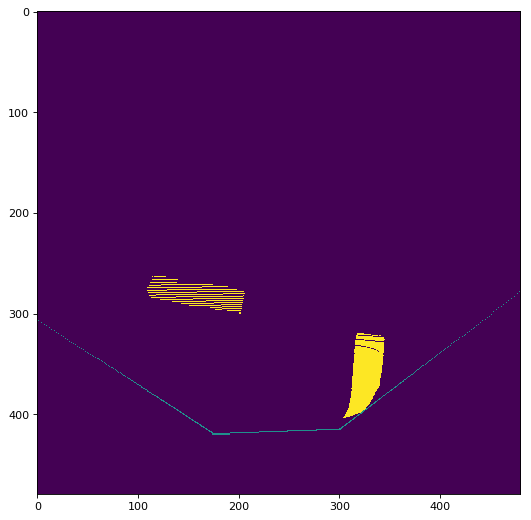

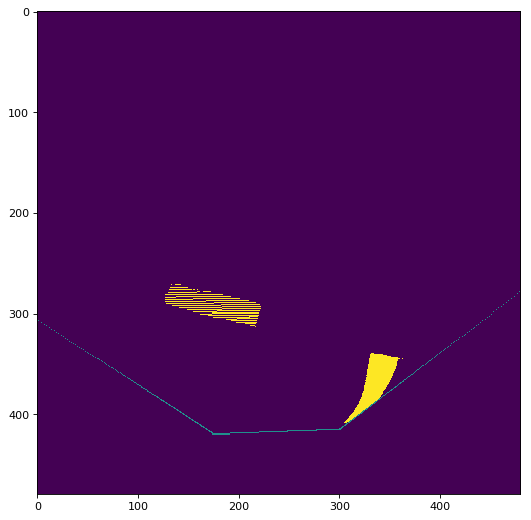

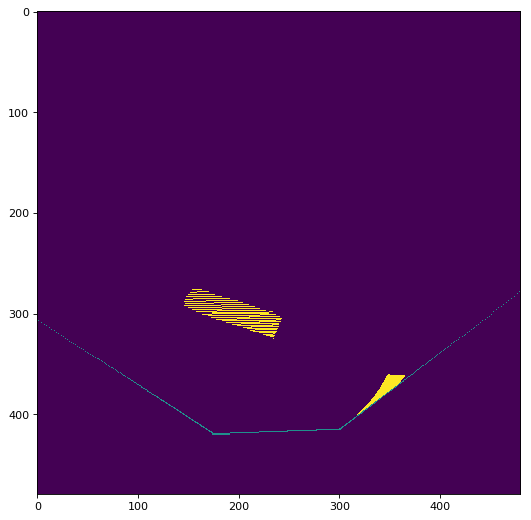

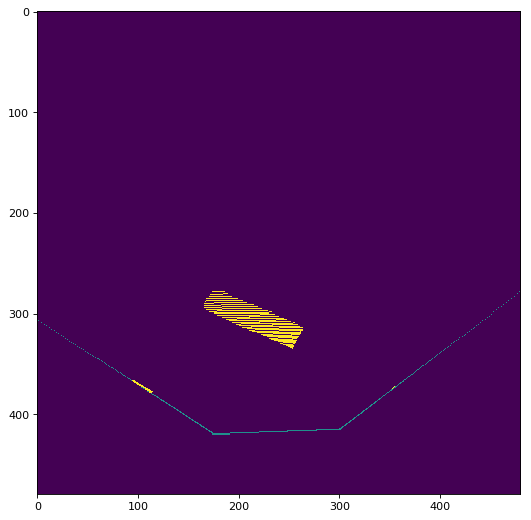

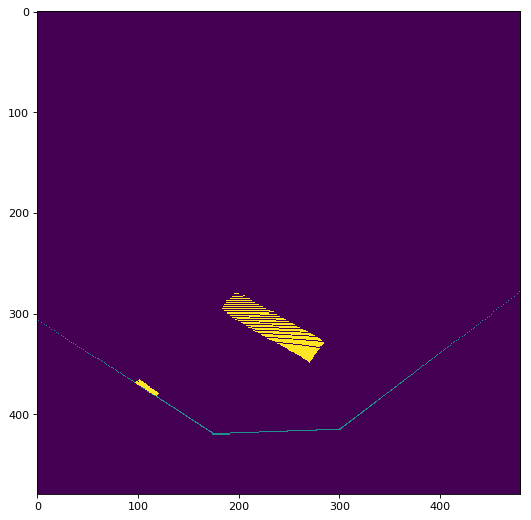

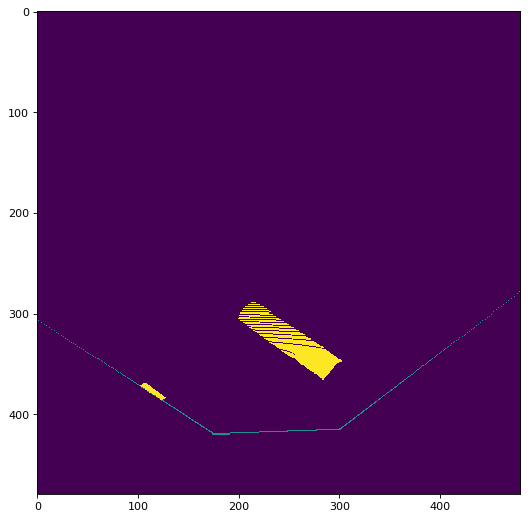

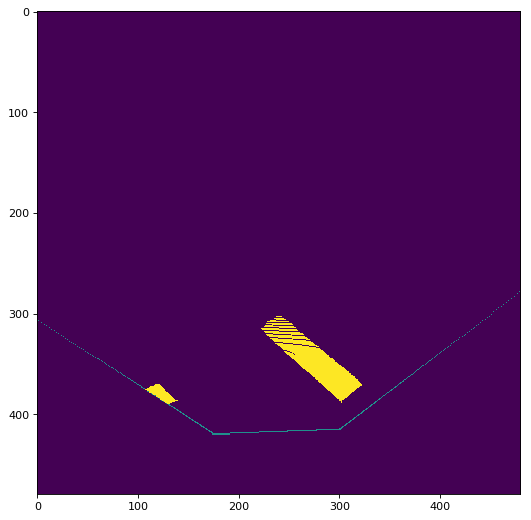

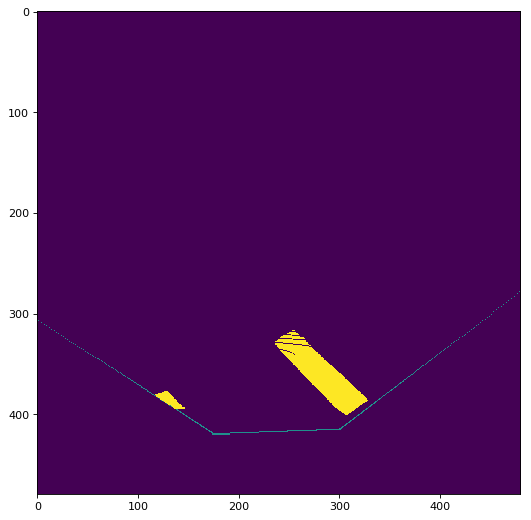

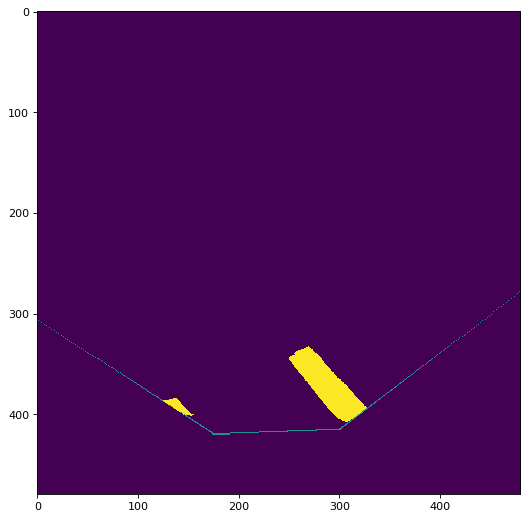

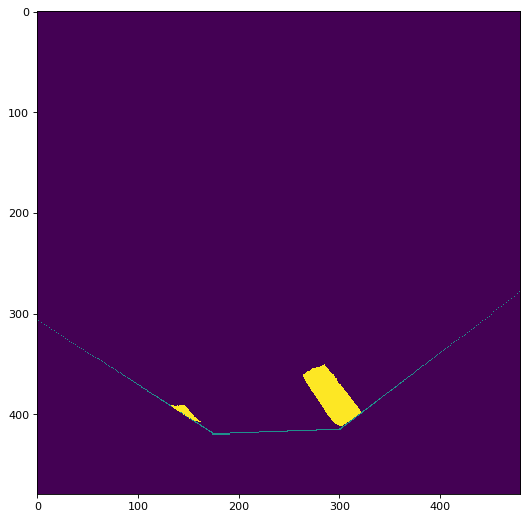

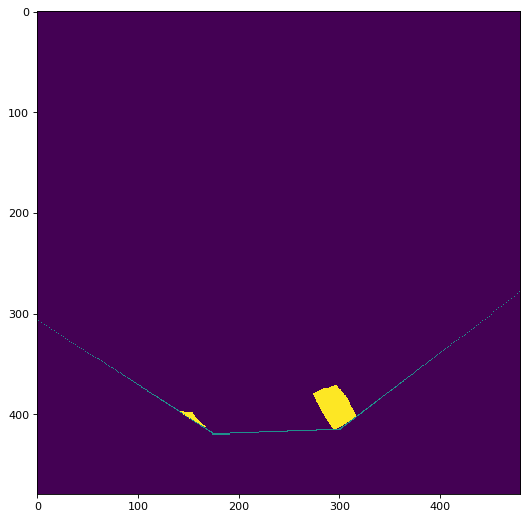

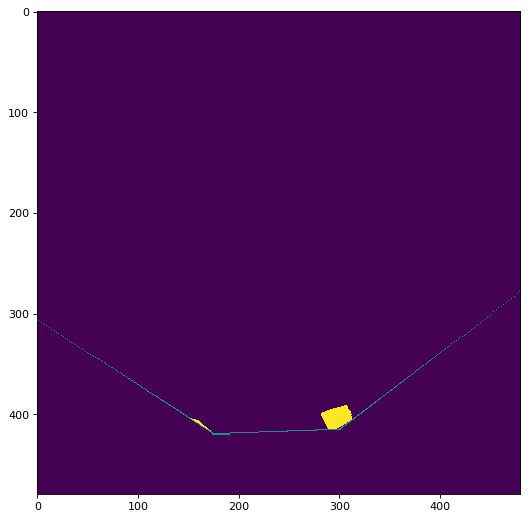

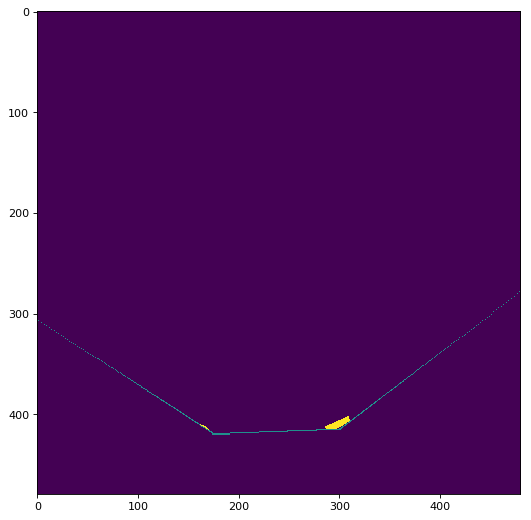

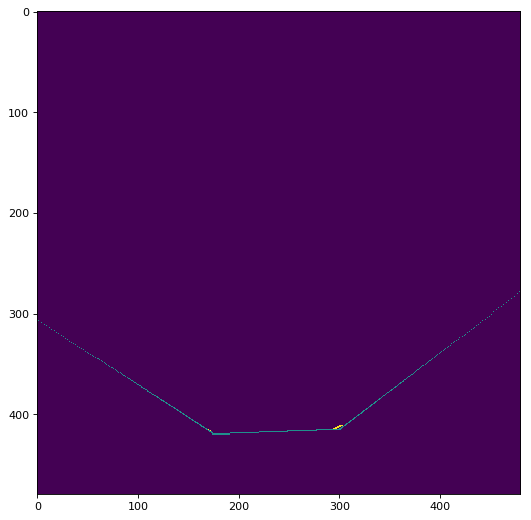

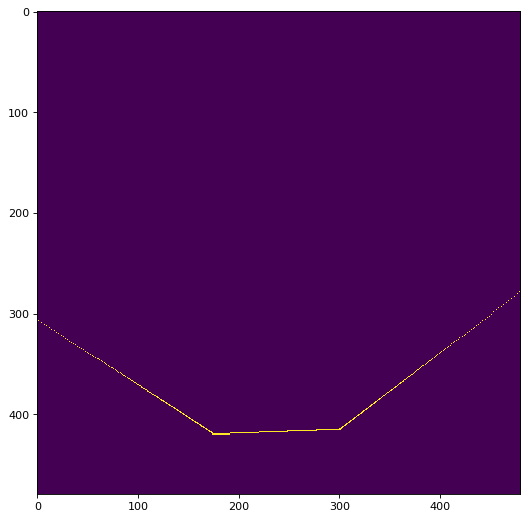

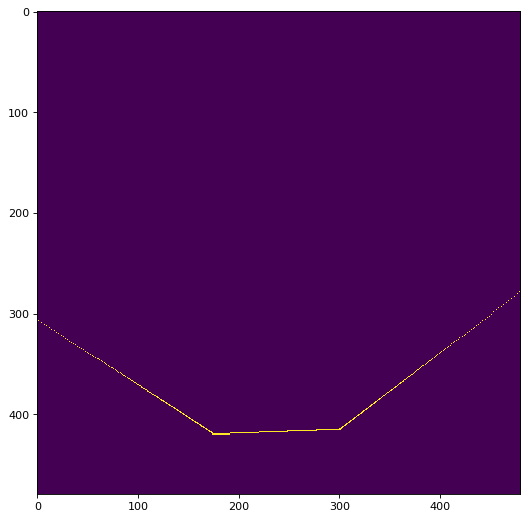

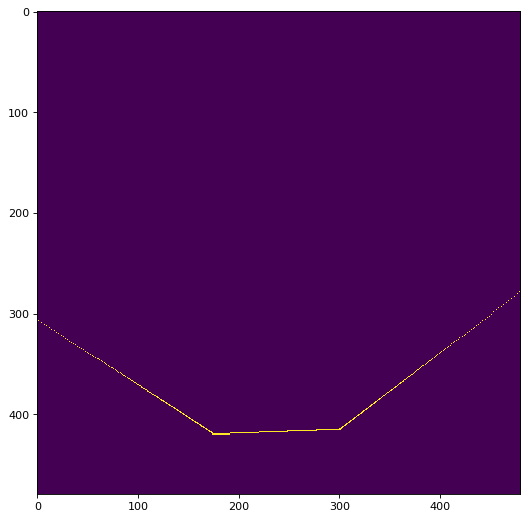

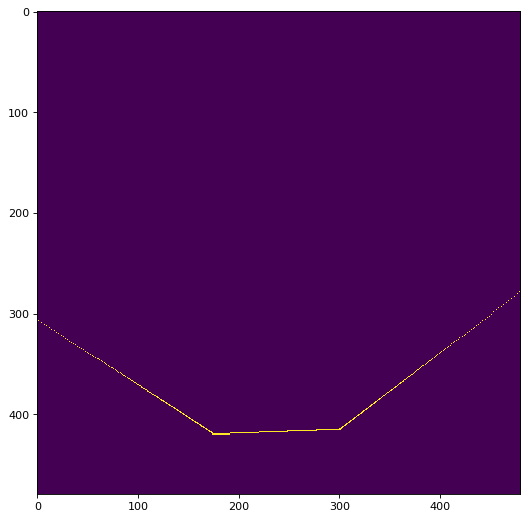

In [61]:
for img in raw:
    red = preprocess(img)
    h, w = np.shape(red)

    #add border to input image so we can see FOV borders in the reprojection
    red[:,(0,w-1)] = 128
    red[(0,h-1),:] = 128
    
    square = ground_project2(red, [0, 0], 1, h)
    imshow(square)
    #divider = np.ones((h,np.floor(output_scale*3)))*255
    #imshow(np.concatenate((img[cutoff:,:,2], divider, square), axis = 1))